In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/modules/')
import functions_grid

# Realistic bathymetry and coordinates grid

The file was formatted specifically to develop a more refined idealized bathymetry in this notebook.

In [2]:
real_file = nc.Dataset('../development_sets/bathy_files/for_refine_mackenzie.nc')
z_real = real_file['Bathymetry'][:,:]
lat_s_grid = real_file['lat_s']
lon_s_grid = real_file['lon_s']

# Get x_wall and y_wall

These are derived from the coordinates grid. That way I can insert it in final_bathymetry.

In [3]:
p_NE = [lon_s_grid[-1,-1], lat_s_grid[-1,-1]]
p_SE = [lon_s_grid[-1,0], lat_s_grid[-1,0]]
p_SW = [lon_s_grid[0,0], lat_s_grid[0,0]]
y_wall = functions_grid.find_distance(p_NE, p_SE)
x_wall = functions_grid.find_distance(p_SW, p_SE)
print(y_wall, x_wall)

405812.746157 547219.334454


# Idealized bathymetry functions

Functions are modified from the original make_mackenzie notebook. This includes the way that y's are calculated using the total size of the domain.

In [49]:
def canyontopo_orig(y, y_base, y_break, y_head, y_coast,
               fluid_depth, z_bottom, z_break, z_wall):
    
    ''' This function generates the topographical profile for the canyon along
    its axis (cross-shore direction). Similar to tanktopo, the profile is
    formed using a collection of lines.
    '''
    
    slc_L = (z_break - z_bottom) / (y_head - y_base)
    slc_ct = (z_wall - z_break) / (y_coast - y_head)
    topo_cp = np.zeros(len(y))
    canyon_profile = np.zeros(len(y))
    
    for ii in np.arange(len(y)):
        
        if y[ii] <= y_base:
            topo_cp[ii] = z_bottom
        
        elif y[ii] > y_base and y[ii] <= y_head:
            topo_cp[ii] = (slc_L * y[ii]) - (slc_L * y_base) + z_bottom
                    
        elif y[ii] > y_head and y[ii] <= y_coast :      
            topo_cp[ii] = (slc_ct * y[ii]) - (slc_ct * y_head) + z_break
          
        elif y[ii] > y_coast:
            topo_cp[ii] = z_wall
        
        canyon_profile[ii] = topo_cp[ii] - fluid_depth
 
    return canyon_profile

# ------------------------------------------------------------------------------------

def define_Mackenzie_measurements(x_wall, y_wall):
    
    ''' This function defines all measurements made
    for Mackenzie Canyon that are used to create 
    the idealized bathymetry profile.
    '''
    
    # Distances
    wall_coast = 26627.0539114
    wall_head = 48259.7140481
    wall_corner = 167520.894219
    wall_base = 174731.93755
    L = 93744.3331621
    
    # Alongshore
    w_break = 62681.735776859277  
    w_mid = 46456.969337226466  
    w_head = 14142.13562373095 
    width_f = 62681.735776859277

    # Cross-shore
    cR = 9246.0  
    y_coast = y_wall - wall_coast
    y_head = y_wall - wall_head
    y_break = (y_wall - wall_head) - L
    y_corner = y_wall - wall_corner
    y_base = y_wall - wall_base
    
    # Depths
    p = 4.0
    fluid_depth = 1300.0
    z_bottom = fluid_depth - fluid_depth
    z_corner = 825
    z_break = fluid_depth - 80.0
    z_wall = fluid_depth - 40.0 
    
    return x_wall, y_wall, w_break, w_mid, w_head, width_f,\
    cR, L, y_coast, y_head, y_break, y_corner, y_base,\
    fluid_depth, z_bottom, z_corner, z_break, z_wall, p

# ------------------------------------------------------------------------------------

def set_domain_grid(xsize, ysize, x_wall, y_wall):
    
    ''' Sets up the domain dimensions and grid cells used
    to generate the canyon bathymetry.
    
    :arg xsize: X direction dimension (alongshore)
    :arg ysize: Y direction dimension (cross-shore)
    '''
    
    xgrd_all = np.arange(0, xsize, 1)
    xgrd_bounds = [0, xsize-1]
    xval_bounds = [0, x_wall]
    xval_all = np.interp(xgrd_all, xgrd_bounds, xval_bounds)
    x_edge = np.zeros(xsize)
    x_edge[:] = xval_all[:]
    x = ((x_edge[1:] + x_edge[0:-1])/2)

    ygrd_all = np.arange(0, ysize, 1)
    ygrd_bounds = [0, ysize-1]
    yval_bounds = [0, y_wall]
    yval_all = np.interp(ygrd_all, ygrd_bounds, yval_bounds)
    y_edge = np.zeros(ysize)
    y_edge[:] = yval_all[:]
    y = ((y_edge[1:] + y_edge[0:-1])/2)

    X, Y = np.meshgrid(x, y)
    
    return x, y, y_edge, X, Y

# ------------------------------------------------------------------------------------

def tanktopo(y, y_base, y_break, y_coast,
             fluid_depth, z_bottom, z_break, z_wall):
    
    ''' This function generates the topographical profile of the continental
    slope and shelf without the canyon. The profile is created in parts using
    the equation of a line: topography = z2 = (m * y2) - (m* y1) + z1, where
    the values for y represent key distances along the cross-shore direction
    and the values for z2 are the calculated depths based on a known z1 depth.
    '''
    
    sls_ct = (z_wall - z_break) / (y_coast - y_break)
    sls_sb = (z_break - z_bottom) / (y_break - y_base)
    topo_sp = np.zeros(len(y))
    slope_profile = np.zeros(len(y))
   
    for jj in np.arange(len(y)):

        if y[jj] > y_base and y[jj] <= y_break:
            topo_sp[jj] = (sls_sb * y[jj]) - (sls_sb * y_base) + z_bottom
                    
        elif y[jj] > y_break and y[jj] < y_coast:
            topo_sp[jj] = (sls_ct * y[jj]) - (sls_ct * y_break) + z_break
                                  
        elif y[jj] >= y_coast:
            topo_sp[jj] = z_wall

        slope_profile[jj] = topo_sp[jj] - fluid_depth
        
    return slope_profile

# ------------------------------------------------------------------------------------
   
def widthprofile(y, y_base, y_break, y_head, y_coast, cR, L,
                 w_break, w_mid, w_head, p):
    
    ''' This function defines the width profile of the canyon (top-down view).
    The width of the canyon is defined for all distances in the cross-shore
    direction. 
    '''

    sigmaa = 1.0 / ((9e-7) * cR)
    half = -w_break / 2.0+ w_mid / 2.0
    e = (L / 2.0 - sigmaa * half**2) / half**p 
    sc = 1
    dG_dxh = p * e * (w_head - w_break / 2)**(p-1) + 2 * sigmaa * (w_head - w_break)
    dh = 0.5 / dG_dxh / sc
    Ah = (w_break - w_head) / (y_base - y_head)**2;
    wp = np.zeros(len(y))

    for l in np.arange(len(y)):

            if y[l] <= y_base:
                wp[l] = w_break

            elif y[l] > y_base and y[l] <= y_head:   
                wp[l] = Ah * (y[l] - y_head)**2 + dh * (y[l] - y_head) + w_head

            elif y[l] > y_head and y[l] <= y_coast:
                wp[l] = wp[l-1]
            
            elif y[l] > y_coast:
                wp[l] = w_break
                
        
    width_profile = wp 
    return width_profile

# ------------------------------------------------------------------------------------

def make_topo_smooth(y, y_base, y_corner, y_break, y_head, y_coast, cR, L,
                     x, x_wall, w_break, w_mid, w_head, p,
                     fluid_depth, z_bottom, z_corner, z_break, z_wall):
    
    ''' This function returns the depth field of the continental slope and
    shelf with a sech-shaped canyon. It uses the functions tanktopo,
    canyontopo, and widthprofile.
    
    :arg y: Array of cross-shore distances
    :arg y_base: Distance to the base of the continental slope
    :arg y_break: Distance to the shelf break
    :arg y_head: Distance to the canyon head
    :arg y_coast: Distance beyond y_head where shelf flattens
    :arg cR: Radius of curvature at the shelf break depth
    :arg x: Array of alongshore distances
    :arg x_wall: Width of the Domain
    :arg w_break: Width of the canyon at the shelf break
    :arg w_mid: Width of the canyon half-way along its length
    :arg w_head: Width of the canyon head
    :arg p: Geometric parameter used to help shape of canyon
    :arg fluid_depth: Total height of the fluid in the domain.
    :arg z_bottom: Depth of the deep ocean (measured upward)
    :arg z_break: Depth of the shelf break (measured upward)
    :arg z_wall: Depth of shelf beyond y_coast (measured upward)
    '''
    
    # Topography without the canyon
    slope_profile = tanktopo(y, y_base, y_break, y_coast,
                             fluid_depth, z_bottom, z_break, z_wall)
    
    canyon_profile = canyontopo(y, y_base, y_corner, y_break, y_head, y_coast,
               fluid_depth, z_bottom, z_corner, z_break, z_wall)
  
    # Slope of the canyon as well as the shape
    width_profile = widthprofile(y, y_base, y_break, y_head, y_coast, cR, L,
                                 w_break, w_mid, w_head, p)
  
    # Depth of the canyon (negative values set to zero)
    canyondepth = slope_profile - canyon_profile
  
    canyondepth[canyondepth < 0] = 0
  
    # Sech shaped canyon
    topography = np.zeros((len(y),len(x)))
    for j in np.arange(len(x)):
        topography[:,j] = (slope_profile - canyondepth * 
                           (1.0 / (np.cosh(0.5 / width_profile * (x[j] - (0.5 * x_wall))))**50))
    topo = -1* topography[0:-1, :]
    topo = np.fliplr(np.rot90(topo, 2))
   
    return topo


def canyontopo(y, y_base, y_corner, y_break, y_head, y_coast,
               fluid_depth, z_bottom, z_corner, z_break, z_wall):
    
    ''' This function generates the topographical profile for the canyon along
    its axis (cross-shore direction). Similar to tanktopo, the profile is
    formed using a collection of lines.
    '''
    
    #changed
    slc_corner = (z_corner - z_bottom) / (y_corner - y_base)
    slc_break = (z_break - z_corner) / (y_head - y_corner)
    
    #unchanged
    slc_ct = (z_wall - z_break) / (y_coast - y_head)
    topo_cp = np.zeros(len(y))
    canyon_profile = np.zeros(len(y))
    
    for ii in np.arange(len(y)):
        
        if y[ii] <= y_base:
            topo_cp[ii] = z_bottom
            
        elif y[ii] > y_base and y[ii] <= y_corner:
            topo_cp[ii] = (slc_corner * y[ii]) - (slc_corner * y_base) + z_bottom
        
        elif y[ii] > y_corner and y[ii] <= y_head:
            topo_cp[ii] = (slc_break * y[ii]) - (slc_break * y_corner) + z_corner
                    
        elif y[ii] > y_head and y[ii] <= y_coast :      
            topo_cp[ii] = (slc_ct * y[ii]) - (slc_ct * y_head) + z_break
          
        elif y[ii] > y_coast:
            topo_cp[ii] = z_wall
        
        canyon_profile[ii] = topo_cp[ii] - fluid_depth
 
    return canyon_profile

# Resulting idealized bathymetry

This set up is modified from what was originally in final_bathymetry. Now, it should be a lot simpler as it takes in consideration the final domain dimensions from the coordinates grid.

In [50]:
x_wall, y_wall, w_break, w_mid, w_head, width_f, cR, L, y_coast, y_head, y_break, y_corner, y_base,\
fluid_depth, z_bottom, z_corner, z_break, z_wall, p = define_Mackenzie_measurements(x_wall, y_wall)

xsize, ysize = z_real.shape[1] + 1, z_real.shape[0] + 1

In [52]:
x, y, y_edge, X, Y = set_domain_grid(xsize, ysize, x_wall, y_wall)

z_ideal = make_topo_smooth(y_edge, y_base, y_corner, y_break, y_head, y_coast, cR, L,
                     x, x_wall, w_break, w_mid, w_head, p,
                     fluid_depth, z_bottom, z_corner, z_break, z_wall)

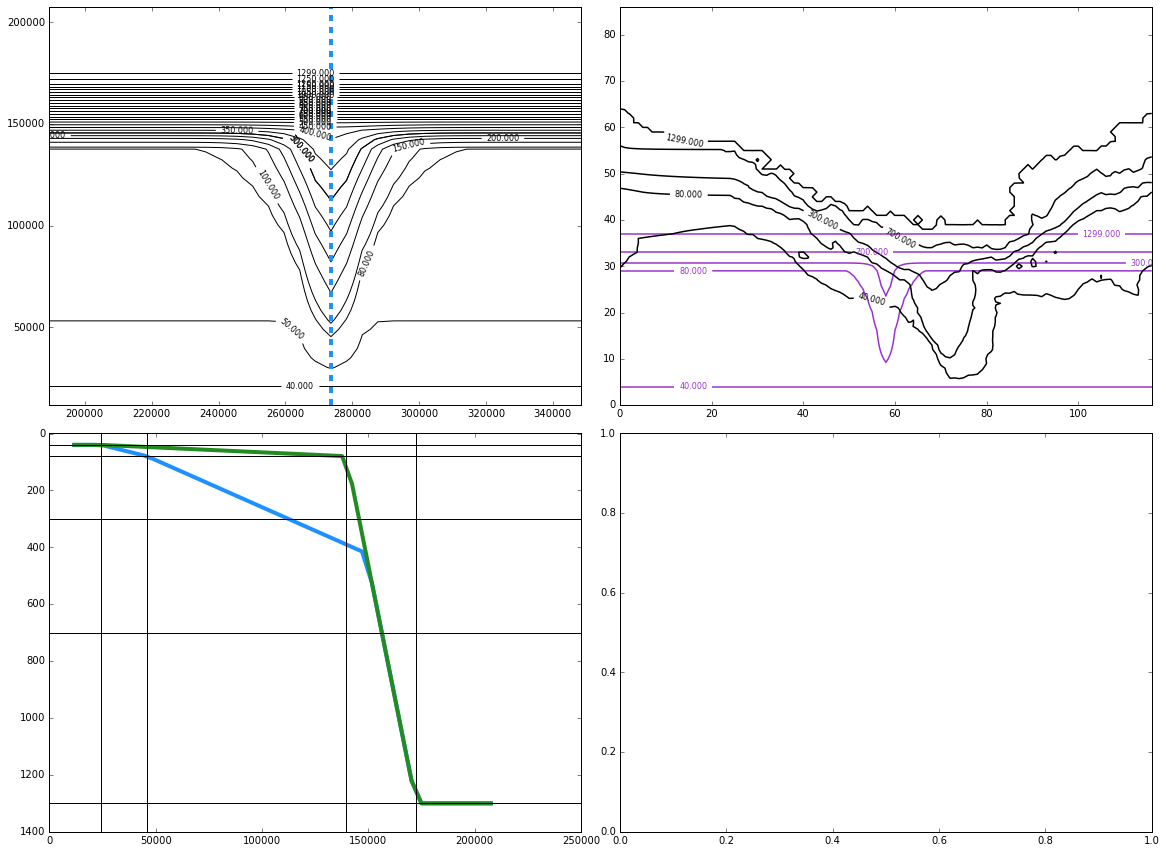

In [54]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(16,12)); plt.tight_layout()

levels = [fluid_depth - z_wall, fluid_depth - z_break, 300, 700, 1299]

c0 = ax1.contour(X[2:45, 40:75], Y[2:45, 40:75], z_ideal[2:45, 40:75], 30, colors='k')
c1 = ax1.contour(X[2:45, 40:75], Y[2:45, 40:75], z_ideal[2:45, 40:75], levels = levels, colors='k')
middle = int(z_ideal.shape[1]/2)
ax1.axvline(X[middle, middle], color='dodgerblue', linestyle='--', linewidth=4)
ax1.clabel(c0, inline=1, fontsize=8)
ax1.clabel(c1, inline=1, fontsize=8)


c2 = ax2.contour(z_ideal, levels, colors='darkorchid', linewidths=1.5)
c3 = ax2.contour(z_real, levels, colors='k', linewidths=1.5)
ax2.clabel(c2, inline=1, fontsize=8)
ax2.clabel(c3, inline=1, fontsize=8)


ax3.plot(Y[2:45, middle], z_ideal[2:45, middle], color='dodgerblue', linewidth=4)
ax3.plot(Y[2:45, -1], z_ideal[2:45, -1], color='forestgreen', linewidth=4)
for z_key in zip(levels):
    ax3.axhline(z_key, c='k')
for y_key in zip([y_base, y_break, y_head, y_coast]):
    ax3.axvline(Y.max() - y_key, c='k')
ax3.invert_yaxis()

# workstation

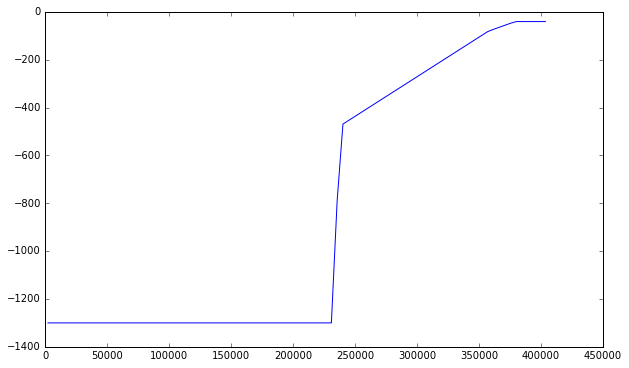

In [23]:

def canyontopo(y, y_base, y_break, y_head, y_coast, y_corner,
               fluid_depth, z_bottom, z_break, z_wall, z_corner):
    
    ''' This function generates the topographical profile for the canyon along
    its axis (cross-shore direction). Similar to tanktopo, the profile is
    formed using a collection of lines.
    '''
    
    #changed
    slc_corner = (z_corner - z_bottom) / (y_corner - y_base)
    slc_break = (z_break - z_corner) / (y_head - y_corner)
    
    #unchanged
    slc_ct = (z_wall - z_break) / (y_coast - y_head)
    topo_cp = np.zeros(len(y))
    canyon_profile = np.zeros(len(y))
    
    for ii in np.arange(len(y)):
        
        if y[ii] <= y_base:
            topo_cp[ii] = z_bottom
            
        elif y[ii] > y_base and y[ii] <= y_corner:
            topo_cp[ii] = (slc_corner * y[ii]) - (slc_corner * y_base) + z_bottom
        
        elif y[ii] > y_corner and y[ii] <= y_head:
            topo_cp[ii] = (slc_break * y[ii]) - (slc_break * y_corner) + z_corner
                    
        elif y[ii] > y_head and y[ii] <= y_coast :      
            topo_cp[ii] = (slc_ct * y[ii]) - (slc_ct * y_head) + z_break
          
        elif y[ii] > y_coast:
            topo_cp[ii] = z_wall
        
        canyon_profile[ii] = topo_cp[ii] - fluid_depth
 
    return canyon_profile

canyon_profile = canyontopo(y, y_base, y_break, y_head, y_coast, y_corner, 
                            fluid_depth, z_bottom, z_break, z_wall, z_corner)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(y, canyon_profile)